# <u><b>Telecom Churn Prediction: Insights and Strategies for Retaining Customers</u></b>
#### <b>Team Name</b>: Bug Bytes
#### <b>Group Memebers</b>: Vanessa Medrano, Lucy Chilling, Avery Gilbert & Itzhak Estrella


## Introduction & Objective
---
In the evolving telecom industry, customer retention is extremely important. Companies strive to figure out the driving factors behind customer churn to implement effective retention strategies. Our data science final project utilizes the IBM Telco Customer Churn dataset, a collection of synthesized  customer data designed to simulate real-world dynamics. Moreover, this dataset provides a unique opportunity to explore various features to identify patterns and predictors of customer churn. Through this project, our group aims to delve deep into the nuances of customer behaviors and service utilization that influence their decisions to stay with or leave their current telecom provider through a human-centered lens.

The primary objective of this project is to develop a predictive model that accurately identifies customers at a high risk of churn. By analyzing a variety of characteristic features that define the uniqueness of each customer, we aim to pinpoint critical factors that contribute to customer departure. Through the application of machine learning techniques and comprehensive data analysis, we anticipate uncovering actionable insights that will significantly impact customer retention strategies in the telecom sector.

## Dataset Overview
---
For this project, we will use IBM's Churn Dataset, which is a synthetic dataset created by IBM to simulate customer churn data. We will extract this dataset from **Kaggle**, which is a platform that hosts various datasets, by using the **Kaggle API** \
\
Documentation on how to install and use the **Kaggle API** can be seen by clicking on this [hyperlink](https://www.kaggle.com/docs/api).\
\
This dataset is licensed by [Apache-2.0 license](https://www.apache.org/licenses/LICENSE-2.0), thus meaning that this dataset can be freely used, modified, and distributed. The dataset is properly sourced at the end of this Jupyter Notebook.


## Data Extraction
---

In [42]:
import pandas as pd
import numpy as np
from IPython.display import display
import os
import json
import pickle
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report
try:
    import lime
except:
    !pip install lime --quiet;
    import lime

from lime import lime_tabular


from google.colab import userdata

# Warnings
import warnings
warnings.filterwarnings("ignore")

SEED = 123                # seed for reproducibility

This notebook is set up to run in a Google Colab environment. The following two code blocks establish the initial setup for acquiring the dataset from Kaggle using Kaggle's API:

In [43]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

kaggle_username = userdata.get('kaggleUsername')
kaggle_key = userdata.get('kaggleKey')

api_token = {"username":kaggle_username,
             "key":kaggle_key}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d yeanzc/telco-customer-churn-ibm-dataset
print('Download Successful')

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset
License(s): other
telco-customer-churn-ibm-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Download Successful


In [44]:
# path to zip file in Google colab
zip_file = '/content/telco-customer-churn-ibm-dataset.zip'

# expected output file
output_file = '/content/Telco_customer_churn.xlsx'

if not os.path.exists(output_file):
    !unzip {zip_file}
    print('Successfully unzipped the data file')
else:
    print('File already exists; skipping unzipping.')

File already exists; skipping unzipping.


Now, let's take a look at the dataset we are working with. We will generate a summary table that describes each feature, detailing its data type, the number of unique values, and the total number of entries with null values.

## Data Exploration
---

In [45]:
 # will be used for analzing and visualizations
churn_df = pd.read_excel(output_file)
# will be used for analzying, visualizations, and modeling
model_df = churn_df.copy(deep = True)

print(f'The size of our dataset: {len(churn_df)} entries')
print(f'Number of features: {churn_df.dtypes.size}')

summary_table = pd.DataFrame({
    'Feature': churn_df.columns,
    'Data Type': [churn_df[col].dtype for col in churn_df.columns],
    'N Unique Values': [churn_df[col].nunique() for col in churn_df.columns],
    'N Null Values': [churn_df[col].isnull().sum() for col in churn_df.columns]
})
display(summary_table)
display(churn_df)

The size of our dataset: 7043 entries
Number of features: 33


,Feature,Data Type,N Unique Values,N Null Values
0,CustomerID,object,7043,0
1,Count,int64,1,0
2,Country,object,1,0
3,State,object,1,0
4,City,object,1129,0
5,Zip Code,int64,1652,0
6,Lat Long,object,1652,0
7,Latitude,float64,1652,0
8,Longitude,float64,1651,0
9,Gender,object,2,0


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,1,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,...,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No,0,45,5306,NaN
7039,6840-RESVB,1,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,...,One year,Yes,Mailed check,84.80,1990.5,No,0,59,2140,NaN
7040,2234-XADUH,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,...,One year,Yes,Credit card (automatic),103.20,7362.9,No,0,71,5560,NaN
7041,4801-JZAZL,1,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,Female,...,Month-to-month,Yes,Electronic check,29.60,346.45,No,0,59,2793,NaN


We will now explore all the features of this dataset to figure out if its necessary to either keep them or drop them for our model implemenation. We have provided a feature table that gives a detailed descrion of what each feature tells us.

Here is a markdown table describing each of the features in the dataset:

| Feature | Description |
|---------|-------------|
| CustomerID | A unique ID that identifies each customer. |
| Count | A value used in reporting/dashboarding to sum up the number of customers in a filtered set. |
| Country | The country of the customer’s primary residence. |
| State | The state of the customer’s primary residence. |
| City | The city of the customer’s primary residence. |
| Zip Code | The zip code of the customer’s primary residence. |
| Lat Long | The combined latitude and longitude of the customer’s primary residence. |
| Latitude | The latitude of the customer’s primary residence. |
| Longitude | The longitude of the customer’s primary residence. |
| Gender | The customer’s gender: Male, Female. |
| Senior Citizen | Indicates if the customer is 65 or older: Yes, No. |
| Partner | Indicates if the customer has a partner: Yes, No. |
| Dependents | Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc. |
| Tenure Months | Indicates the total number of months that the customer has been with the company by the end of the specified quarter. |
| Phone Service | Indicates if the customer subscribes to home phone service with the company: Yes, No. |
| Multiple Lines | Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No. |
| Internet Service | Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable. |
| Online Security | Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No. |
| Online Backup | Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No. |
| Device Protection | Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No. |
| Tech Support | Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No. |
| Streaming TV | Indicates if the customer uses their Internet service to stream television programming from a third party provider: Yes, No. The company does not charge an additional fee for this service. |
| Streaming Movies | Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service. |
| Contract | Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year. |
| Paperless Billing | Indicates if the customer has chosen paperless billing: Yes, No. |
| Payment Method | Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check. |
| Monthly Charge | Indicates the customer’s current total monthly charge for all their services from the company. |
| Total Charges | Indicates the customer’s total charges, calculated to the end of the quarter specified above. |
| Churn Label | Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value. |
| Churn Value | 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label. |
| Churn Score | A score from 0-100 calculated using the predictive tool IBM SPSS Modeler, incorporating factors known to cause churn. The higher the score, the more likely the customer will churn. |
| CLTV | Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High-value customers should be monitored for churn. |
| Churn Reason | A customer’s specific reason for leaving the company. Directly related to Churn Category. |


In [46]:
model_df.dtypes

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
Churn Score            int64
CLTV                   int64
Churn Reason          object
dtype: object

## Data Preprocessing
---

After taking a close look at our features from the summary table that we created, we have decided to drop the following features since they all contain a single unique value which wont be helpful for our model:
- `Count`
- `Country`
- `State`

In [47]:
model_df = model_df.drop(columns = ['Count', 'Country', 'State'], axis = 1)

The `CustomerID` column does not contribute to predicting customer churn, so we have decided to remove this column from the dataset as well.

In [48]:
model_df = model_df.drop(columns = ['CustomerID'], axis = 1)

Next, we observed that `Churn Reason` was the only feature that contained a significant amount of **Null** values per entry. We have decided not to retain this feature for our model since it is impossible to impute, and removing all **Null** entries would significantly reduce our sample size.

In [49]:
model_df = model_df.drop(columns = ['Churn Reason'], axis = 1)

We also determined that incorporating the `Churn Score` and `CLTV` into our model would not be an ethical decision, as we want to avoid our model being influenced by scores from other machine learning models (from IBM).

In [50]:
model_df = model_df.drop(columns = ['Churn Score', 'CLTV'], axis = 1)

Lastly, we saw that `City` contained a lot of unique object-type values which would be really hard to convert to numerical features. That is why the team has decided to drop all featuers that are related to location (`City`, `Lat Long`, `Latitude`, `Longitude` and `Zip Code`).

In [51]:
model_df = model_df.drop(columns = ['City', 'Lat Long', 'Latitude', 'Longitude', 'Zip Code'], axis = 1)

We also noticed that one of the features in the dataset, `Total Charges`, was incorrectly defined as a string object when it should have been defined as a *float* type when the CSV file was converted into a Pandas dataframe.

In [52]:
churn_df['Total Charges'] = pd.to_numeric(churn_df['Total Charges'],
                                          errors = 'coerce')
model_df['Total Charges'] = pd.to_numeric(model_df['Total Charges'],
                                          errors = 'coerce')

# check to see if there are any null values after data encoding
print(f"Number of Null values in `Total Charges` column: {churn_df['Total Charges'].isnull().sum()}")

'''
We saw that there are a few Null values in `Total Charges` column, therefore we
will impute the missing values by using the mean as our imputation method.
'''
# replace Null values with the mean of the column
mean_total_charges = churn_df['Total Charges'].mean()
churn_df['Total Charges'] = churn_df['Total Charges'].fillna(mean_total_charges)
model_df['Total Charges'] = model_df['Total Charges'].fillna(mean_total_charges)

Number of Null values in `Total Charges` column: 11


Both `Churn Value` and `Churn Label` serve the same purpose. However, we will stick to `Churn Label` to be our main target variable, thus deciding to drop `Churn Value`.

In [53]:
model_df = model_df.drop(columns = ['Churn Value'], axis = 1)

# Using Data Visualizations to Deepen Analysis Insights
---

The following helper method is designed to depict churning rate proportions based on features from the dataset. This will help up come with useful analysis such as whether gender affects churn rate and etc.

In [54]:
def percentage_stacked_plot(columns_to_plot, suptitle):

    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows))
    fig.suptitle(suptitle, fontsize=22,  y=.95)


    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # calculate
        independant_var = pd.crosstab(churn_df[column],
                                      churn_df['Churn Label']).apply(lambda x: x/x.sum()*100, axis=1)

        independant_var.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0, color=['lightgreen','lightcoral'])

        # set the legend
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)

        # set title and labels
        ax.set_title(column + ' Proportions',
                     fontsize=16, weight = 'bold')

        ax.tick_params(rotation='auto')


##Demographic Data

Now that we have a helper function that helps us with visualizing the churn rate from a given attribute, we have decided to explore and analyze churn rate from demographic data such as: `Gender`, `Senior Citizen`, `Partner`, and `Dependents`.

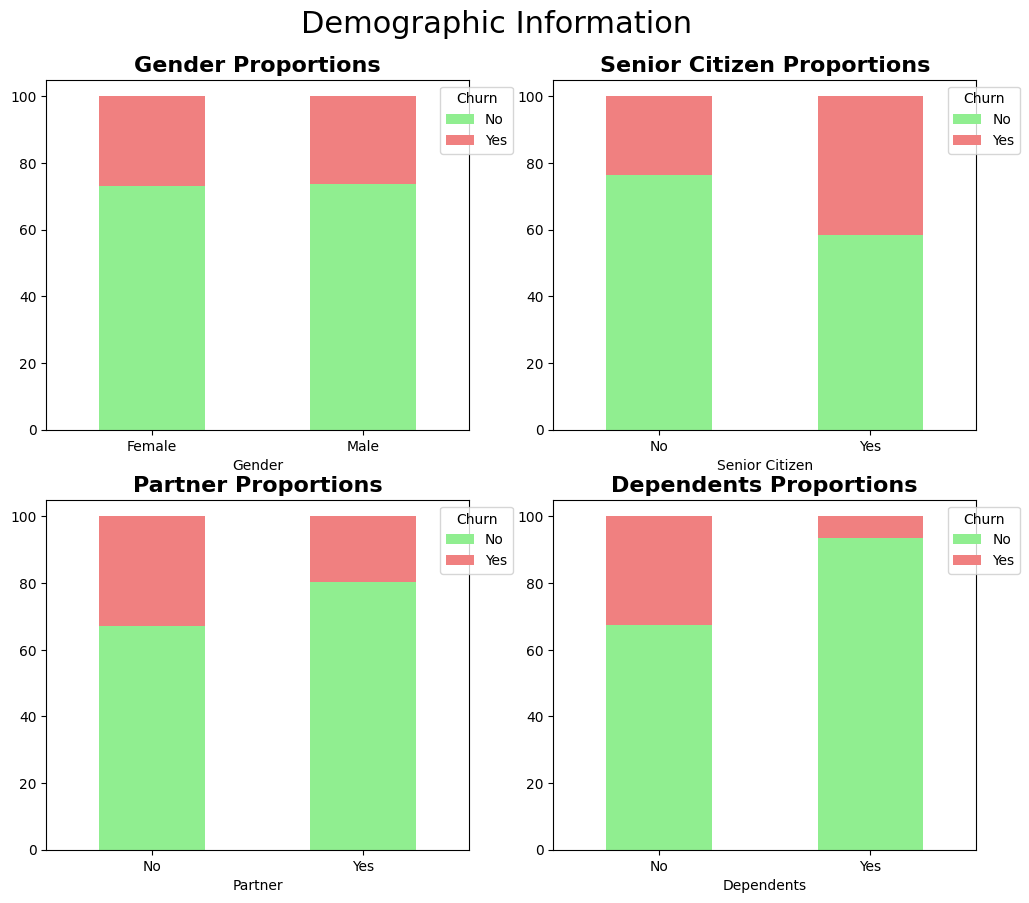

In [55]:
demograph_columns = ['Gender', 'Senior Citizen', 'Partner', 'Dependents']

percentage_stacked_plot(demograph_columns, 'Demographic Information')

Based on analyzing the demographic attributes of people from the dataset we can come to a few conclusions:


- Gender doesn't seem to affect churn rate
- The churn rate of senior citizens is higher than the churn rate of non senior citizens
- Customers with partners churn less than those who don't have a partner
- Customers with dependents churn significantly less than those without dependents



Although gender does not appear to affect churn rate, we have decided to exclude it from our learning dataset as an ethical choice to prevent potential bias in our predictions as we have learned previously in class.

In [56]:
model_df = model_df.drop(columns = ['Gender'], axis = 1)

## Payment Information

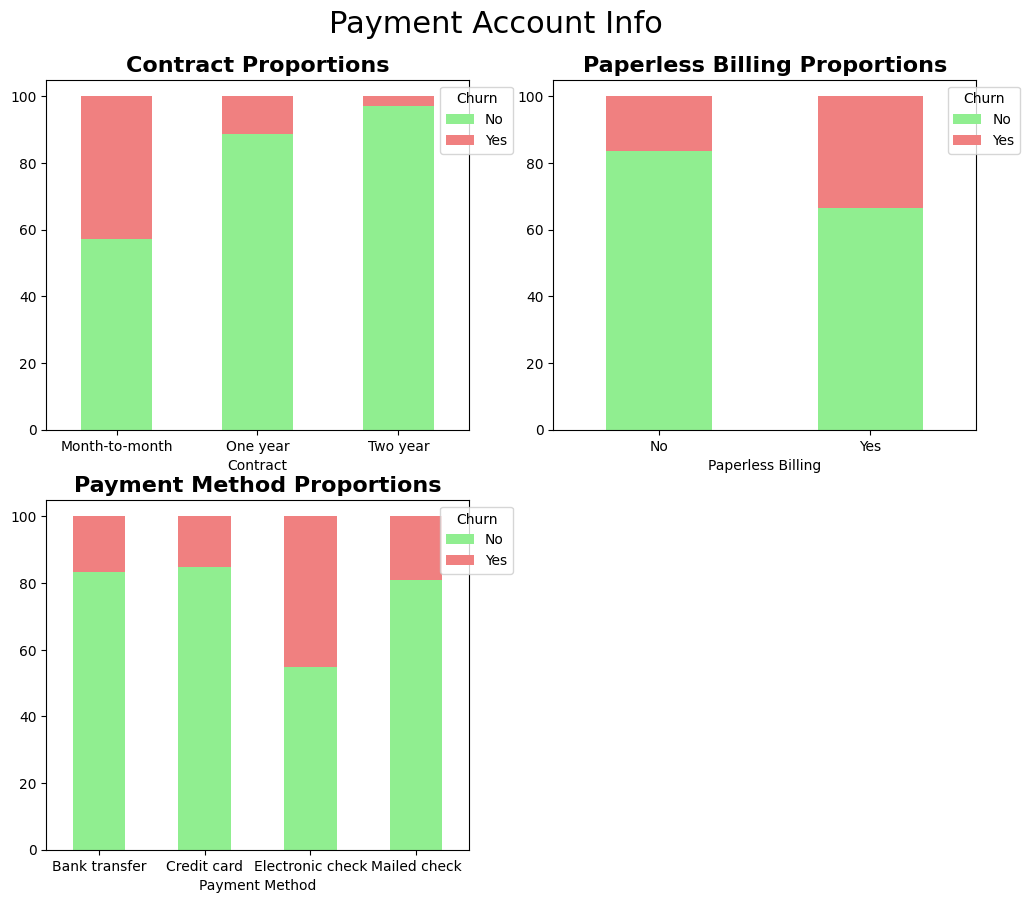

In [57]:
payment_columns = ['Contract', 'Paperless Billing', 'Payment Method']

#Remove (automatic) from 'Payment Method' column
churn_df['Payment Method'] = churn_df['Payment Method'].str.replace(' (automatic)', '', regex=False)

percentage_stacked_plot(payment_columns, 'Payment Account Info')

Based on analyzing the payment account attributes we can come to the following conclusions:


- Customers with longer contract (i.e. 1-2 years) are less likely to churn than customers that have a month to month contract
- Customers who utilize paperless billing are more likely to churn than customers who don't
- Customers who utilize the Electronic check method are much more likely to churn than those who use the alternative payment methods



## Service Information Graph

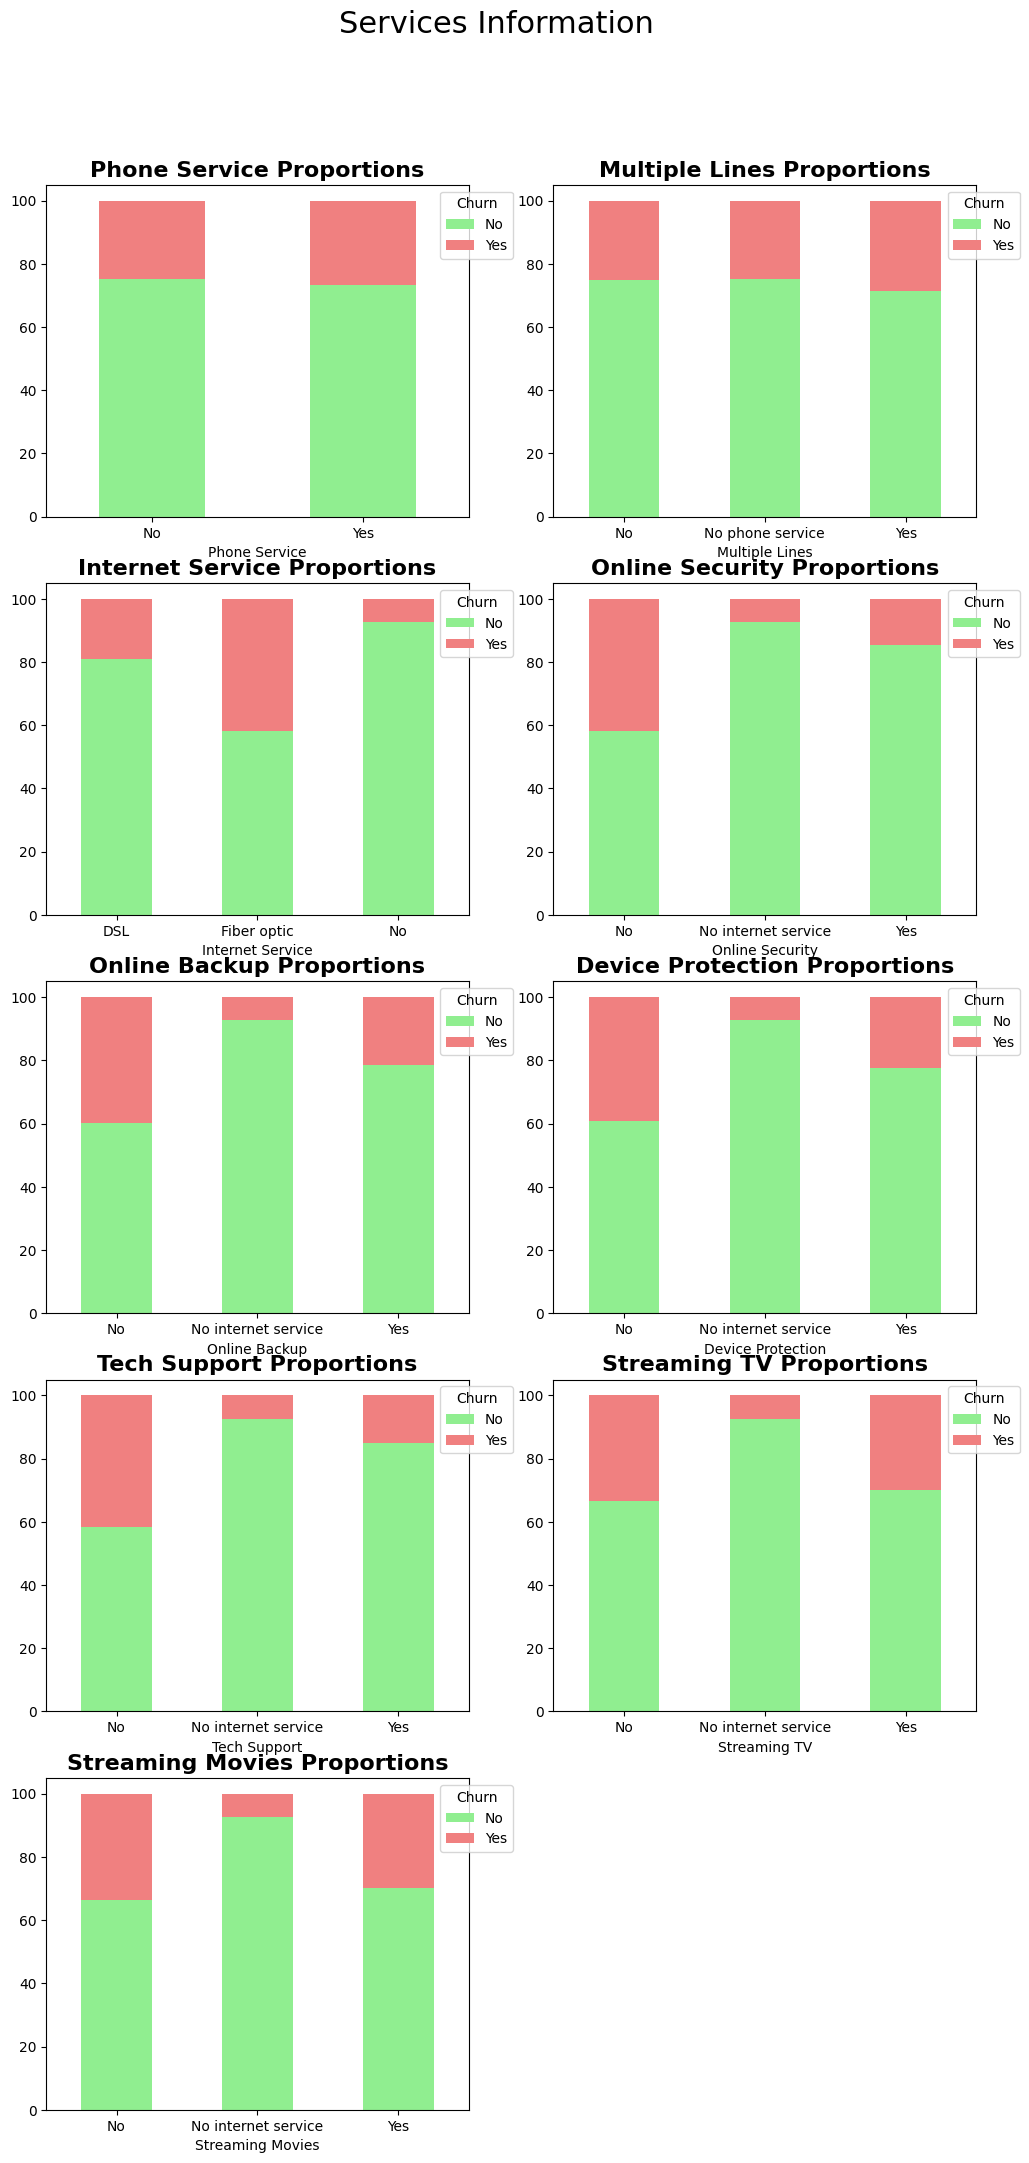

In [58]:
#Service information
services_columns = ['Phone Service', 'Multiple Lines', 'Internet Service',
                    'Online Security', 'Online Backup', 'Device Protection',
                    'Tech Support', 'Streaming TV', 'Streaming Movies']

# stacked plot of services columns
percentage_stacked_plot(services_columns, 'Services Information')

Based on these graphs we can determine the following.


- The 'Phone Service' and 'Multiple Lines' features don't appear to have any difference and won't assist us in predicing churn
- Those with Fiber optic internet service are more likely to churn
- Customers without 'Online Security' are more likely to churn than those with Online Security
- Customers with 'Online Backups' and 'Device Protection' are less likely to churn than those without
-  Customers without 'Tech Support' are more likely to churn than those that have tech support
- For both 'Streaming TV' and 'Streaming Movies' those with "no internet service" are less likely to churn than those with internet service to stream



## Numeric Feature Visualizations


In [59]:
def histogram_plots(columns_to_plot, super_title):
  # set number of rows and number of columns
  number_of_columns = 2
  number_of_rows = math.ceil(len(columns_to_plot)/2)

  # create a figure
  fig = plt.figure(figsize=(12, 5 * number_of_rows))
  fig.suptitle(super_title, fontsize=22,  y=.95)


  # loop to each demographic column name to create a subplot
  for index, column in enumerate(columns_to_plot, 1):

    # create the subplot
    ax = fig.add_subplot(number_of_rows, number_of_columns, index)
    # histograms for each class (normalized histogram)
    #https://stackoverflow.com/questions/67146435/how-can-i-overlap-two-parts-in-plt-hist
    churn_df[churn_df['Churn Label']=='No'][column].plot(kind='hist', ax=ax, density=True,
                                                    alpha=0.5, color='lightgreen', label='No')
    churn_df[churn_df['Churn Label']=='Yes'][column].plot(kind='hist', ax=ax, density=True,
                                                    alpha=0.5, color='lightcoral', label='Yes')

    # set the legend in the upper right corner
    ax.legend(loc="upper right", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5),
              title='Churn', fancybox=True)

    # set title and labels
    ax.set_title('Distribution of ' + column + ' by Churn',
                  fontsize=16, loc='left')

    ax.tick_params(rotation='auto')

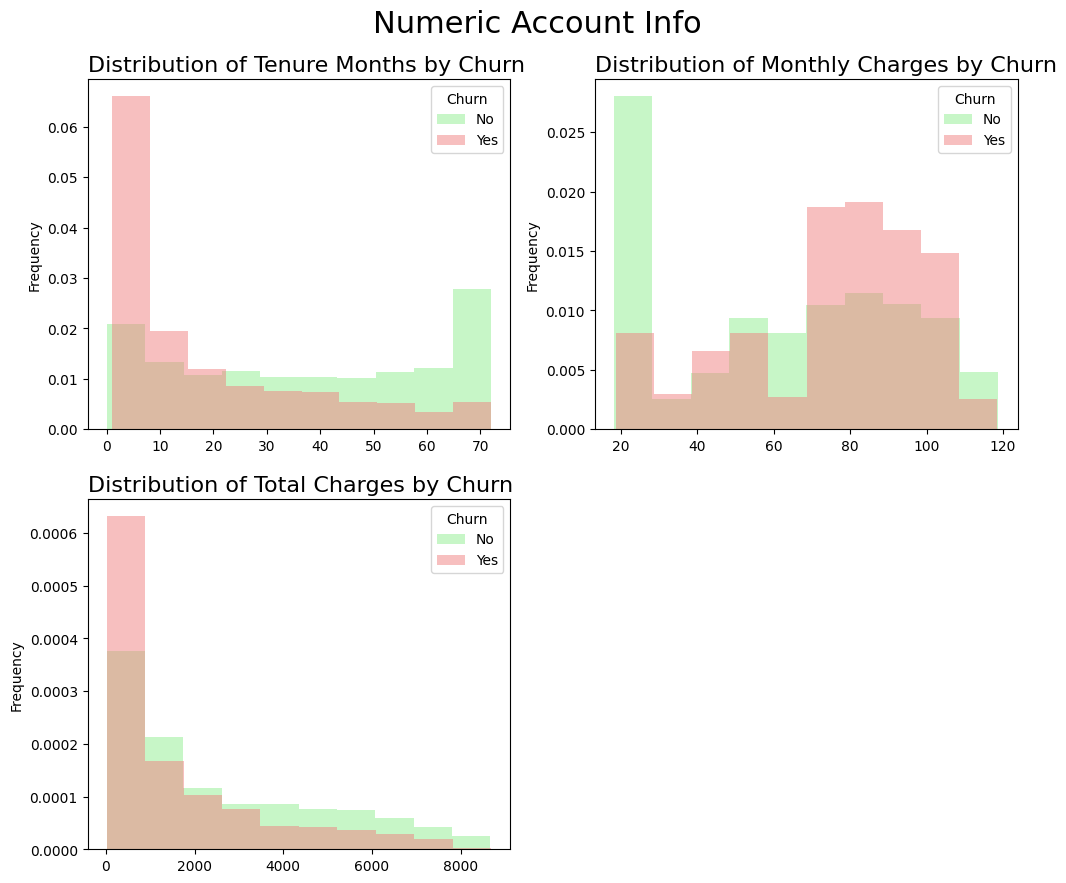

In [60]:
numeric_account_col = ['Tenure Months', 'Monthly Charges', 'Total Charges']

histogram_plots(numeric_account_col, 'Numeric Account Info')

From these graphs we can determine that:


- New customers are much more likely to Churn than those with long Tenure
- The Churn rate is much higher as monthly charges increase
- Customers with a higher `Total Charge` are less likely to churn than customers who haven't invested much on `Total Charge` into the company.



# Feature Engineering and Feature Transformation
---

As seen through the data exploration phase of our project, we observed several categorical variables, especially binary categorical variables. Considering that we have eliminated a significant number of features so far, the team thought it would be a good idea to transform our binary features into a numerical form defined appropriately (values of 0 and 1). Moreover, we also decided to normalize our continous features by using the min-max normalization technique since logistic regression requires normalization to prevent the vanishing gradient problem during the training phase.

 Additionally, we plan to perform a feature engineering technique known as one-hot encoding on features that contain more than two unique categorical values. This approach will be particularly useful when we construct our Pearson Correlation Matrix, which only calculates correlation scores for numerical features.

In [61]:
new_model_df = model_df.copy()
# --------------------------- FEATURE ENGINEERING  -----------------------------
# one-hot encoding (categorical variables with more than two levels)
one_hot_encoding_columns = ['Multiple Lines', 'Internet Service',
                            'Online Security', 'Online Backup',
                            'Device Protection', 'Tech Support', 'Streaming TV',
                            'Streaming Movies', 'Contract', 'Payment Method']

# encode categorical variables with more than two levels using one-hot encoding
new_model_df = pd.get_dummies(new_model_df,
                                      columns = one_hot_encoding_columns)

# ------------------------ FEATURE TRANSFORMATION ------------------------------
# label encoding (binary variables)
label_encoding_columns = ['Partner', 'Dependents',
                          'Paperless Billing', 'Phone Service',
                          'Churn Label', 'Senior Citizen']


# encode categorical binary features using label encoding
for column in label_encoding_columns:
      new_model_df[column] = new_model_df[column].map({'Yes': 1, 'No': 0})


# min-max normalization (numeric variables)
continous_columns = ['Tenure Months', 'Monthly Charges', 'Total Charges']

# scale numerical variables using min max scaler
for column in continous_columns:
        # minimum value of the column
        min_column = new_model_df[column].min()
        # maximum value of the column
        max_column = new_model_df[column].max()
        # min max scaler
        new_model_df[column] = (new_model_df[column] - min_column) / (max_column - min_column)

# show our new transformed model
display(new_model_df.head())

,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Paperless Billing,Monthly Charges,Total Charges,Churn Label,Multiple Lines_No,...,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,0,0,0,0.027778,1,1,0.354229,0.010310,1,True,...,True,False,False,True,False,False,False,False,False,True
1,0,0,1,0.027778,1,1,0.521891,0.015330,1,True,...,True,False,False,True,False,False,False,False,True,False
2,0,0,1,0.111111,1,1,0.809950,0.092511,1,False,...,False,False,True,True,False,False,False,False,True,False
3,0,1,1,0.388889,1,1,0.861194,0.349325,1,False,...,False,False,True,True,False,False,False,False,True,False
4,0,0,1,0.680556,1,1,0.850249,0.578987,1,False,...,False,False,True,True,False,False,True,False,False,False


# Pearson Correlation for Feature Selection
---

By creating a Pearson Correlation Matrix, we will be able to determine which variables in our dataset have a linear relationship with each other (especially with our target variable). This allows us to identify pairs of variables that are positively or negatively correlated, thus providing insights for our feature selection, understanding variable interactions, and improving the accuracy and interpretability of our chosen predictive models.

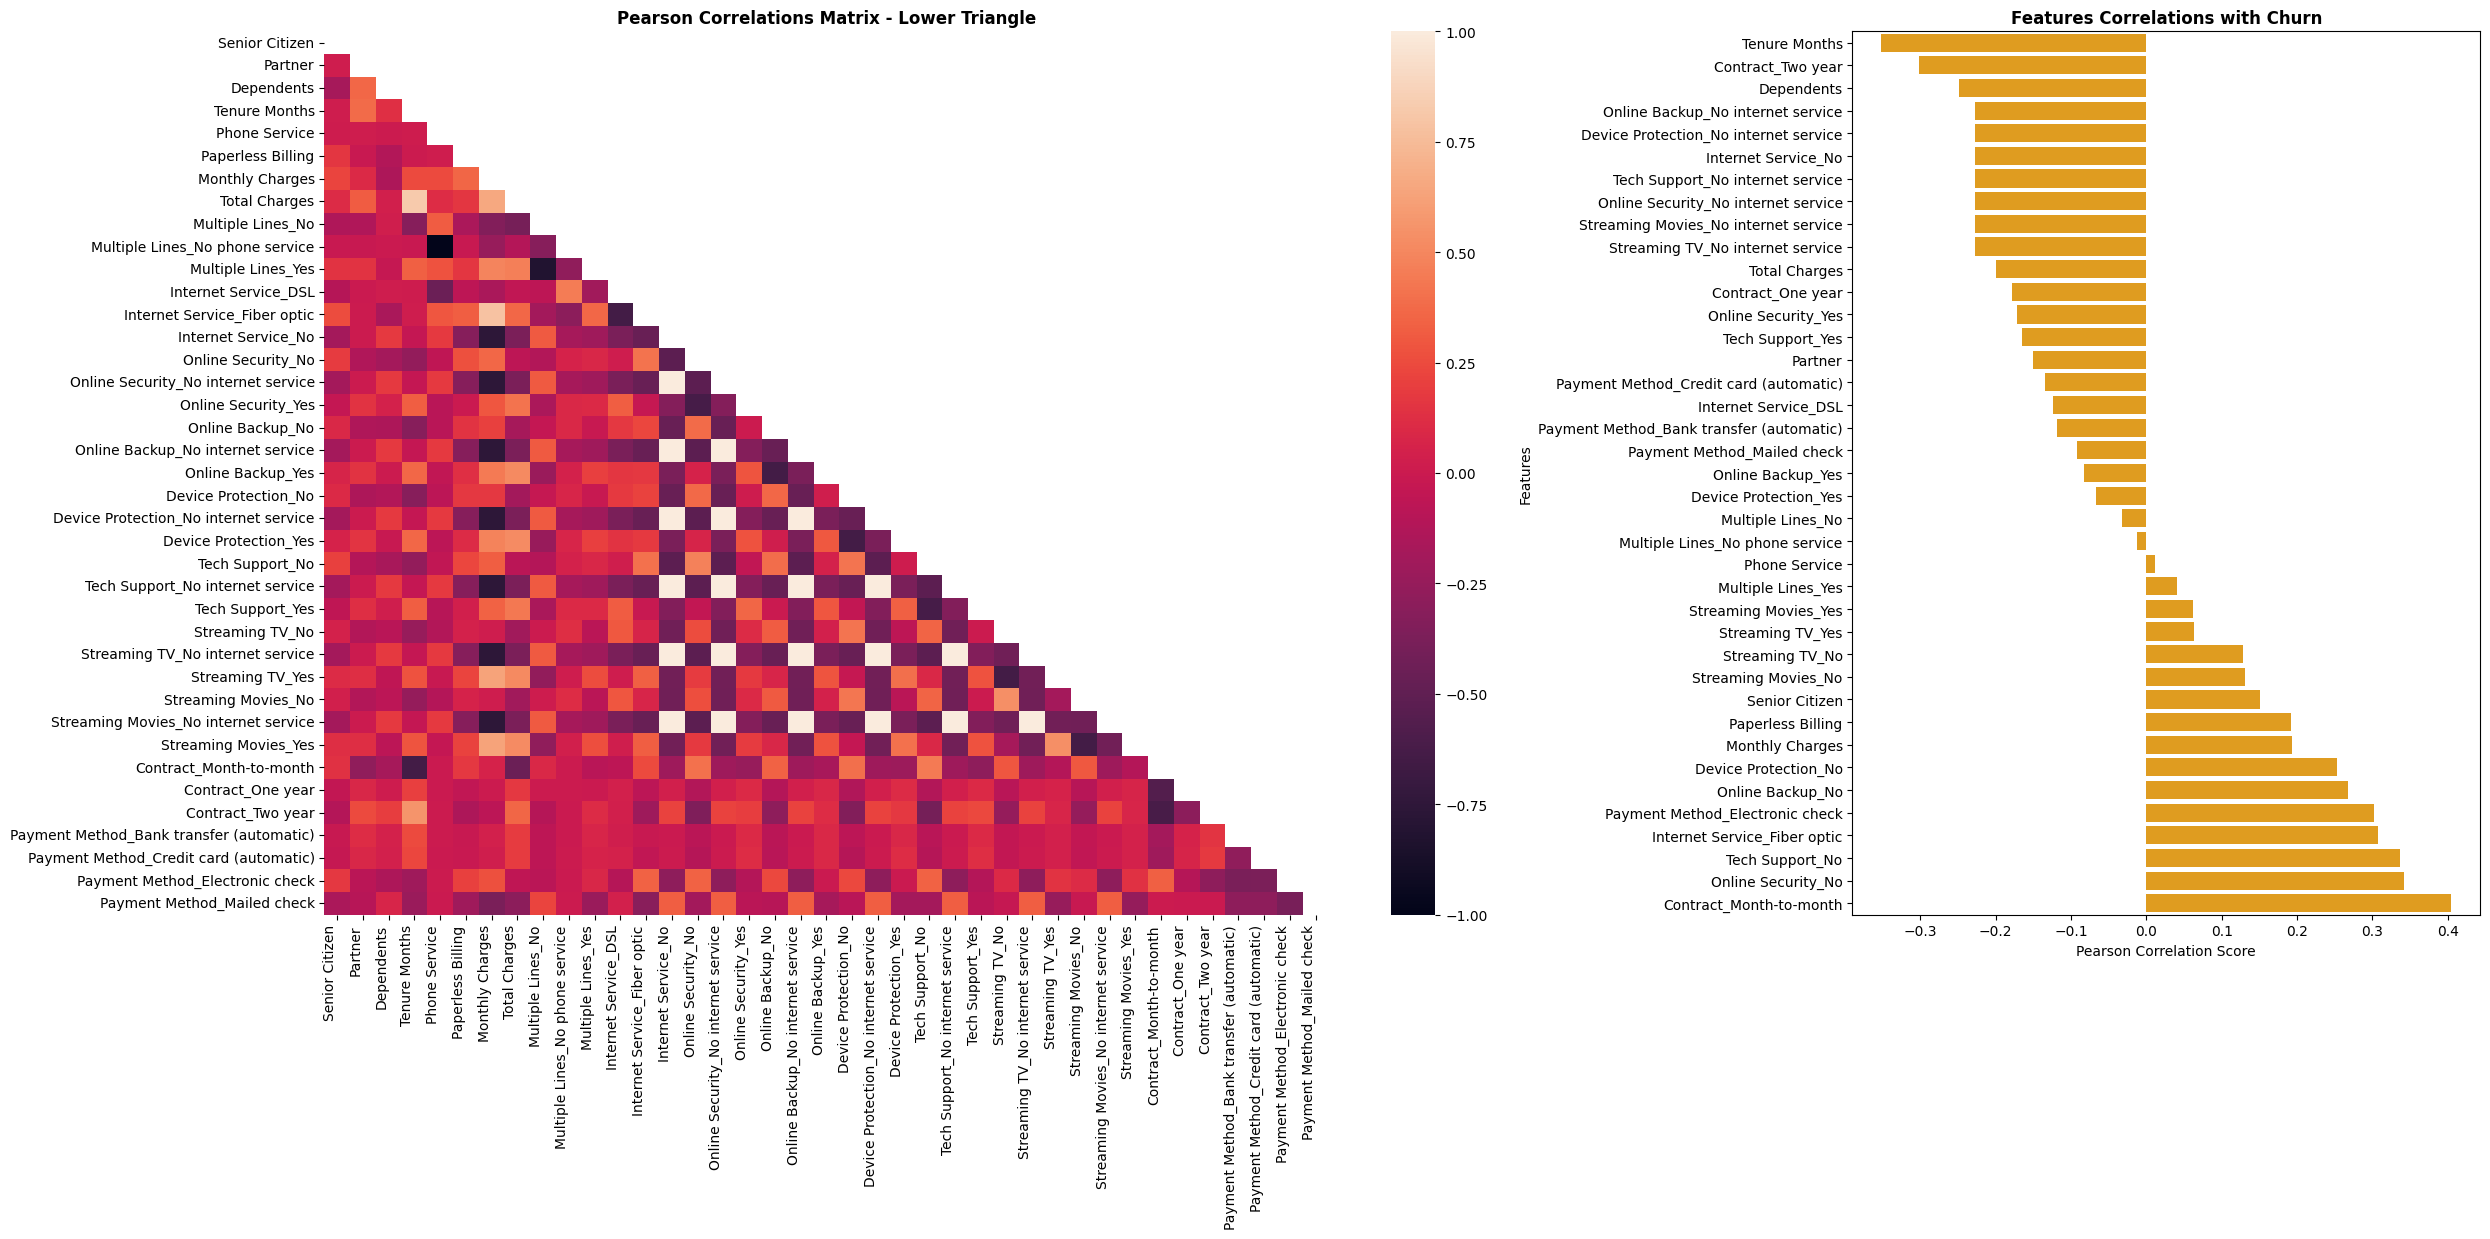

In [72]:
def plot_correlations(df, figsize=(12.5, 6.5)):
    # we won't modify the original dataframe.
    df_copy = df.copy().dropna()

    # the corr() method accepts numerical features only. So first we change the categories values of each feature for a number representation.
    for feature in df_copy.columns:
        if pd.api.types.is_object_dtype(df_copy[feature]):
            df_copy[feature] = pd.Categorical(df_copy[feature]).codes

    corr = df_copy.corr()

    # plot a heatmap of the correlation matrix.
    _, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize, gridspec_kw={"width_ratios": [2, 1]})
    corr_features = corr.drop("Churn Label", axis="rows").drop("Churn Label", axis="columns")
    mask = np.triu(np.ones_like(corr_features, dtype=bool))
    sns.heatmap(corr.drop("Churn Label", axis="rows").drop("Churn Label", axis="columns"), mask=mask, ax=ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90, ha="right")
    ax1.set_title("Pearson Correlations Matrix - Lower Triangle", fontweight='bold')

    # display a barplot for the features correlations with the target "Churn Label" feature.
    churn_corr = corr['Churn Label'].sort_values().drop("Churn Label")
    sns.barplot(x=churn_corr.values, y=churn_corr.index, ax=ax2, color='orange')
    ax2.set_title("Features Correlations with Churn", fontweight='bold')
    ax2.set_ylabel("Features")
    ax2.set_xlabel("Pearson Correlation Score")
    plt.tight_layout()

plot_correlations(new_model_df, figsize=(25, 12.5))

# Feature Selection
---
For this section, we will create a subset of our model dataset, selecting only the features that exhibit a negative correlation between -1 and -0.2, as well as those with a positive correlation between 0.2 and 1. We are doing this to eliminate numerous features that fall within the (-0.2, 0.2) range. This step is taken because our models are sensitive to the curse of dimensionality. By applying these defined thresholds, we hope to achieve better accuracies.

In [70]:
# calc the correlation matrix from above
corr_matrix = new_model_df.corr()

# filter features based on correlation with the target variable
selected_features = corr_matrix[(corr_matrix['Churn Label'] <= -0.2) |
                                (corr_matrix['Churn Label'] >= 0.2)]


filtered_features = selected_features.index.drop('Churn Label')
subset_model_df = new_model_df[filtered_features.tolist() + ['Churn Label']]
print(f'New dimensionality: {subset_model_df.shape}')
display(subset_model_df.head())

New dimensionality: (7043, 18)


,Dependents,Tenure Months,Internet Service_Fiber optic,Internet Service_No,Online Security_No,Online Security_No internet service,Online Backup_No,Online Backup_No internet service,Device Protection_No,Device Protection_No internet service,Tech Support_No,Tech Support_No internet service,Streaming TV_No internet service,Streaming Movies_No internet service,Contract_Month-to-month,Contract_Two year,Payment Method_Electronic check,Churn Label
0,0,0.027778,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,1
1,1,0.027778,True,False,True,False,True,False,True,False,True,False,False,False,True,False,True,1
2,1,0.111111,True,False,True,False,True,False,False,False,True,False,False,False,True,False,True,1
3,1,0.388889,True,False,True,False,True,False,False,False,False,False,False,False,True,False,True,1
4,1,0.680556,True,False,True,False,False,False,False,False,True,False,False,False,True,False,False,1


# Building Predictive Models
---
In the study of customer churn prediction for telecommunications services, we employed two different predictive models: logistic regression and random forests, using the Scikit-learn library which provides pre-implemented machine learning algorithms.

To optimize both models, hyperparameter tuning was conducted using the GridSearchCV function from Scikit-learn. GridSearchCV automates the process of finding the most effective parameters (hyperparameters) for a given model.

For our training and testing criteria, we will split the dataset to 25% testing and 75% training.

In [64]:
# select independent variables
X = new_model_df.drop(columns='Churn Label')
X_r = subset_model_df.drop(columns='Churn Label')


# select dependent variables
y = new_model_df.loc[:, 'Churn Label']
y_r = subset_model_df.loc[:, 'Churn Label']

# split the data in training and testing sets with superset - 25% test, 75% train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=SEED, shuffle=True)

# split the data in training and tesitng sets with subset
X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_r, y_r, test_size=0.25,
                                                    random_state=SEED, shuffle=True)

# hyper parameters we want to test and use
rf_hp = {
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [50, 100, 150]
}

lr_hp = {
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'max_iter': [250, 500, 1000]
}

lr_model = LogisticRegression()

rf_model = RandomForestClassifier()

lr_clf = GridSearchCV(lr_model, lr_hp, scoring='accuracy', cv=5)
lr_r_clf = GridSearchCV(lr_model, lr_hp, scoring='accuracy', cv=5)

rf_clf = GridSearchCV(rf_model, rf_hp, scoring='accuracy', cv=5)
rf_r_clf = GridSearchCV(rf_model, rf_hp, scoring='accuracy', cv=5)

# --------------Non-Feature Selected Dataset--------------
lr_clf.fit(X_train, y_train)

rf_clf.fit(X_train, y_train)

print('Logistic Regression Performance:')
print(f'Best hyperparameters: {lr_clf.best_params_}')
print(f'Best Accuracry Score: {lr_clf.best_score_}')
print()
print('Random Forests Perfromance:')
print(f'Best hyperparameters: {rf_clf.best_params_}')
print(f'Best Accuracry Score: {rf_clf.best_score_}')
print('\n------------------------------------------\n')

# ----------------Feature Selected Dataset----------------
lr_r_clf.fit(X_r_train, y_r_train)

rf_r_clf.fit(X_r_train, y_r_train)

print('Logistic Regression Performance (On Reduced Dataset):')
print(f'Best hyperparameters: {lr_r_clf.best_params_}')
print(f'Best Accuracry Score: {lr_r_clf.best_score_}')
print()
print('Random Forests Perfromance (On Reduced Dataset):')
print(f'Best hyperparameters: {rf_r_clf.best_params_}')
print(f'Best Accuracry Score: {rf_r_clf.best_score_}')

Logistic Regression Performance:
Best hyperparameters: {'max_iter': 250, 'penalty': None, 'solver': 'saga'}
Best Accuracry Score: 0.8095428026719418

Random Forests Perfromance:
Best hyperparameters: {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 100}
Best Accuracry Score: 0.7972388262951176

------------------------------------------

Logistic Regression Performance (On Reduced Dataset):
Best hyperparameters: {'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Best Accuracry Score: 0.8027276669246868

Random Forests Perfromance (On Reduced Dataset):
Best hyperparameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 100}
Best Accuracry Score: 0.7750849316246666


Only having accuracy can be misslead. Lets print out their classification reports.

In [65]:
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, lr_clf.predict(X_test)))
print()
print("Random Forest - Classification Report:")
print(classification_report(y_test, rf_clf.predict(X_test)))
print()
print("Logistic Regression - Classification Report (Reduced Dataset):")
print(classification_report(y_r_test, lr_r_clf.predict(X_r_test)))
print()
print("Random Forest -  Classification Report (Reduced Dataset):")
print(classification_report(y_r_test, rf_r_clf.predict(X_r_test)))

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1295
           1       0.65      0.57      0.61       466

    accuracy                           0.81      1761
   macro avg       0.75      0.73      0.74      1761
weighted avg       0.80      0.81      0.80      1761


Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1295
           1       0.61      0.51      0.56       466

    accuracy                           0.79      1761
   macro avg       0.72      0.70      0.71      1761
weighted avg       0.78      0.79      0.78      1761


Logistic Regression - Classification Report (Reduced Dataset):
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1295
           1       0.64      0.54      0.59       466

    accuracy                     

Now lets compute some confusion matrices to make our classification reports a lot readible.

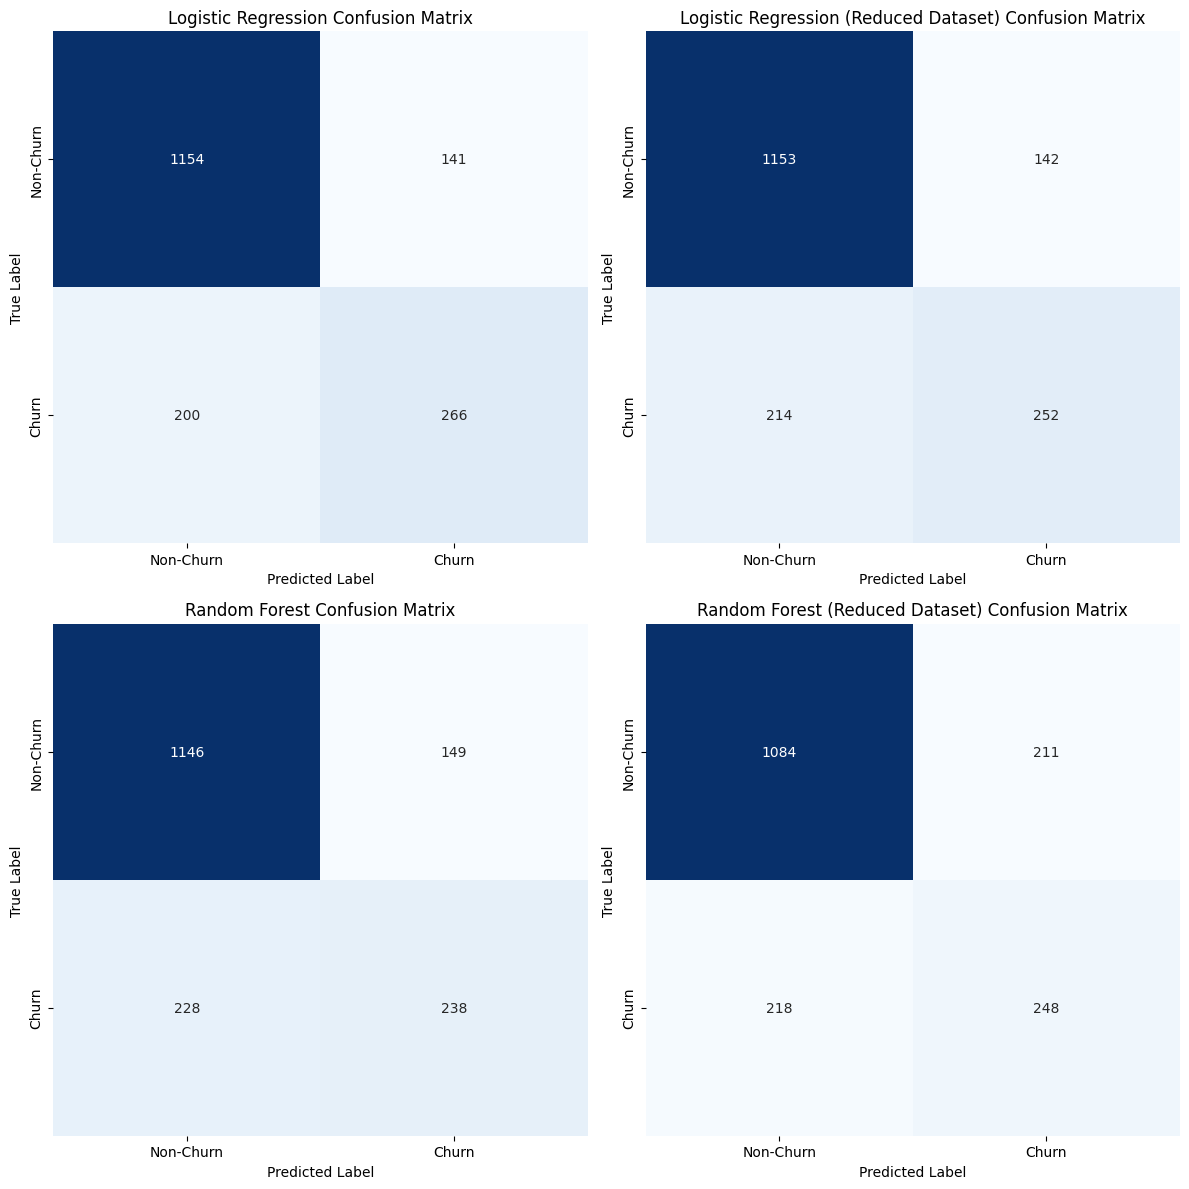

In [66]:
def plot_confusion_matrix(ax, y_pred, table_name):
    # convert predictions to binary classes
    threshold = 0.5
    y_pred_binary = (y_pred > threshold).astype(int)

    conf_matrix = confusion_matrix(y_test, y_pred_binary)

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Churn', 'Churn'], yticklabels=['Non-Churn', 'Churn'], ax=ax)
    ax.set_title(f"{table_name} Confusion Matrix")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# plot confusion matrices
plot_confusion_matrix(axes[0, 0], lr_clf.predict(X_test), "Logistic Regression")
plot_confusion_matrix(axes[0, 1], lr_r_clf.predict(X_r_test), "Logistic Regression (Reduced Dataset)")
plot_confusion_matrix(axes[1, 0], rf_clf.predict(X_test), "Random Forest")
plot_confusion_matrix(axes[1, 1], rf_r_clf.predict(X_r_test), "Random Forest (Reduced Dataset)")

plt.tight_layout()
plt.show()

## Confusion Matrix
---
The confusion matrix provides a structured summary of a binary classification model's performance. It's a square matrix that helps assess the quality of predictions made by the model. In binary classification, the matrix has four key terms:

1. True Positives (TP): These are cases where the model correctly predicts the positive class (e.g., correctly predicting churn).
2. True Negatives (TN): These are cases where the model correctly predicts the negative class (e.g., correctly predicting non-churn).
3. False Positives (FP): These are cases where the model incorrectly predicts the positive class (e.g., predicting churn when it's actually non-churn).
4. False Negatives (FN): These are cases where the model incorrectly predicts the negative class (e.g., predicting non-churn when it's actually churn).
##Classification Report:
The classification report provides a detailed summary of the model's performance, including precision, recall, F1-score, and support for each class (0 and 1).
### Precision:
Precision for class 0 (non-churn) is 0.85, which means that out of all instances predicted as non-churn, 85% are actually non-churn.
Precision for class 1 (churn) is 0.63, which means that out of all instances predicted as churn, 63% are actually churn.
Higher precision values indicate a lower false positive rate.
### Recall:
Recall for class 0 (non-churn) is 0.89, which means that 89% of all actual non-churn instances were correctly predicted as non-churn.
Recall for class 1 (churn) is 0.54, which means that only 54% of all actual churn instances were correctly predicted as churn.
Higher recall values indicate a lower false negative rate.
### F1-score:
F1-score for class 0 (non-churn) is 0.87, which indicates a balance between precision and recall for non-churn instances.
F1-score for class 1 (churn) is 0.58, which indicates a lower balance between precision and recall for churn instances.
F1-score is particularly useful when there is an imbalance between the number of instances in different classes.
### Accuracy:
Accuracy is the ratio of correctly predicted observations to the total observations.
Accuracy measures the overall correctness of the model across all classes.
Accuracy for the model is 0.80, which means that 80% of all instances were correctly classified by the model.
### Support:
Support refers to the number of instances for each class in the dataset.
In this case, there are 1316 instances of class 0 (non-churn) and 445 instances of class 1 (churn).
Support helps in understanding the distribution of instances across different classes and can be useful for interpreting the performance of the model, especially in the context of imbalanced datasets.

Now that we have explained all the scoring metrics, lets show them through two seperate bar graphs that represent the datasets.

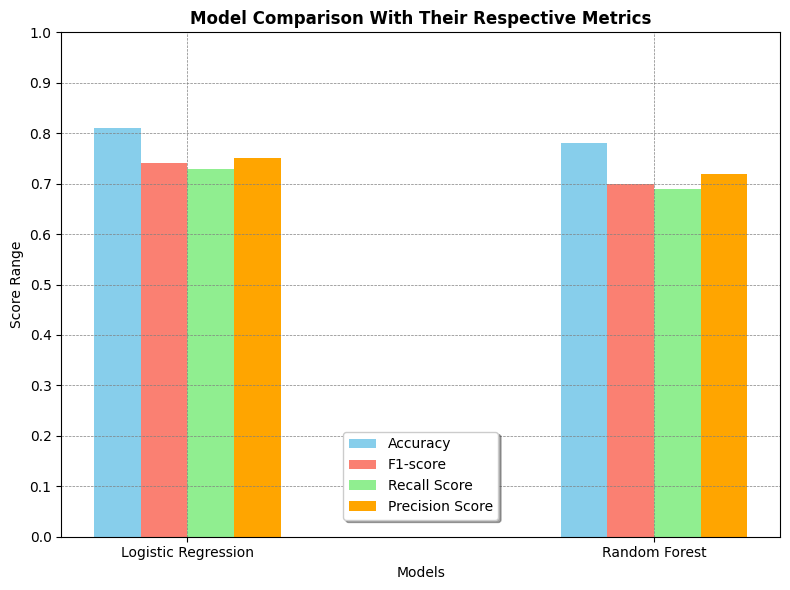

In [71]:
models = ['Logistic Regression', 'Random Forest']

# hardcoded values that are from the classification reports above
accuracy = [0.81, 0.78]
f1_score = [0.74, 0.70]
recall_score = [0.73, 0.69]
precision_score = [0.75, 0.72]

num_metrics = len(models)
bar_width = 0.1
index = np.arange(num_metrics)

fig, ax = plt.subplots(figsize=(8, 6))
# bar = repspective metric
bar1 = ax.bar(index - bar_width * 1.5, accuracy, bar_width, label='Accuracy', color='skyblue')
bar2 = ax.bar(index - bar_width * 0.5, f1_score, bar_width, label='F1-score', color='salmon')
bar3 = ax.bar(index + bar_width * 0.5, recall_score, bar_width, label='Recall Score', color='lightgreen')
bar4 = ax.bar(index + bar_width * 1.5, precision_score, bar_width, label='Precision Score', color='orange')

ax.set_xlabel('Models')
ax.set_ylabel('Score Range')
ax.set_title('Model Comparison With Their Respective Metrics', fontweight="bold")
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
ax.set_xticks(index)
ax.set_xticklabels(models)
plt.yticks(np.arange(0, 1.1, 0.1))
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 0.02), shadow=True, ncol=1)
plt.tight_layout()
plt.show()


Now lets do the same with the reduced dataset that we constructed.

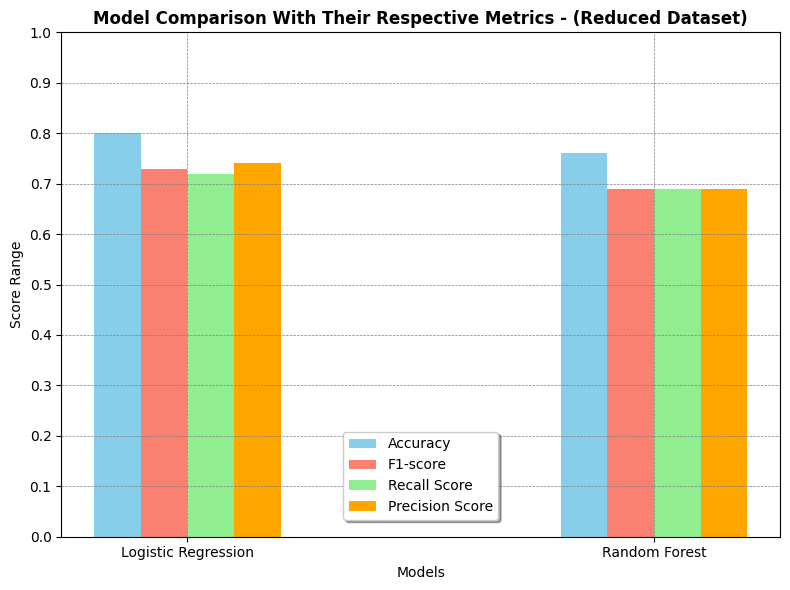

In [68]:
accuracy = [0.80, 0.76]
f1_score = [0.73, 0.69]
recall_score = [0.72, 0.69]
precision_score = [0.74, 0.69]

# new plot
fig, ax = plt.subplots(figsize=(8, 6))
bar1 = ax.bar(index - bar_width * 1.5, accuracy, bar_width, label='Accuracy', color='skyblue')
bar2 = ax.bar(index - bar_width * 0.5, f1_score, bar_width, label='F1-score', color='salmon')
bar3 = ax.bar(index + bar_width * 0.5, recall_score, bar_width, label='Recall Score', color='lightgreen')
bar4 = ax.bar(index + bar_width * 1.5, precision_score, bar_width, label='Precision Score', color='orange')

ax.set_xlabel('Models')
ax.set_ylabel('Score Range')
ax.set_title('Model Comparison With Their Respective Metrics - (Reduced Dataset)', fontweight="bold")
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
ax.set_xticks(index)
ax.set_xticklabels(models)
plt.yticks(np.arange(0, 1.1, 0.1))
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 0.02), shadow=True, ncol=1)
plt.tight_layout()
plt.show()

## LIME Explainer (On Best Model)
---

In [69]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data = X_train.to_numpy(),
    feature_names = X_train.columns.tolist(),
    class_names = ['Non-Churn', 'Churn'],
    mode = 'classification'
)

# choose a specific instance from the test set for explanation
instance_idx = 346
instance = X_test.iloc[[instance_idx]]

# explain the prediction
exp = explainer.explain_instance(
    data_row = instance.to_numpy()[0],
    predict_fn = lr_clf.predict_proba
)
# show explanation in notebook
exp.show_in_notebook(show_table=True)

## Conclusions
---

Based on the analysis of the churn dataframe, several conclusions can be drawn, along with corresponding recommendations for Telco stakeholders to reduce customer churn:

New Customer Onboarding: New customers are more likely to churn compared to long-tenured ones. Therefore, enhancing the onboarding experience and incentivizing long-term commitment can significantly reduce churn among new subscribers.

Pricing Strategy Optimization: As monthly charges increase, so does the churn rate. To address this, Telcos should review their pricing strategies, offering more flexible plans or discounts to cater to diverse customer segments, thereby mitigating churn associated with higher charges.

Encouraging Investment: Customers who have invested more in total charges exhibit lower churn rates. Telcos should encourage customers to upgrade their services or invest in value-added features, fostering greater loyalty and reducing churn.

Feature Relevance: Features like phone service and multiple lines show minimal impact on churn prediction. Telcos should prioritize other factors with more substantial influence on churn, such as service reliability and customer support.

Service Improvement: Customers with fiber optic internet service are more likely to churn, indicating dissatisfaction. Telcos should address network reliability and customer support issues promptly to retain these customers.

Security and Support: Customers without online security or tech support are prone to churn. Emphasizing the benefits of these features and enhancing support services can increase customer retention.

Billing and Payment Methods: Paperless billing and electronic checks are associated with higher churn rates. Telcos should improve digital billing experiences and offer diverse payment options to reduce churn related to billing and payment methods.

Demographic Considerations: While gender doesn't significantly affect churn rate, senior citizens tend to churn more. Tailoring services and marketing efforts to meet their needs can mitigate churn in this demographic.

Family-Oriented Offerings: Customers with partners or dependents exhibit lower churn rates. Developing family-friendly services and promoting the benefits of inclusive plans can reduce churn among these customer segments.

By addressing these insights and implementing corresponding recommendations, Telco stakeholders can create more cohesive retention strategies, ultimately reducing churn and improving customer satisfaction and loyalty.

## References
---
* https://towardsdatascience.com/end-to-end-machine-learning-project-telco-customer-churn-90744a8df97d

* https://github.com/ShivaliPatel/Data-science-projects/blob/master/Telco_customer_churn/Notebooks/Telecom%20Churn%20Prediction-v2.ipynb
